In [1]:
import numpy as np
from pysr import PySRRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from data_preprocessing import data_preprocess
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
pd.set_option('display.max_colwidth', None)
from sympy import sympify
import os

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
def r2_calc(y, y_pred):
    r2 =r2_score(y, y_pred)
    print("R2 score: ", r2)
    return r2, y, y_pred

def mse_calc(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    print("Mean Squared Error: ", mse)
    return mse

def error_percentage(y, y_pred):
    percentage = np.abs((y - y_pred) / y) * 100
    # delete inf values in percentage
    percentage = percentage[percentage != np.inf]
    error = np.mean(percentage)
    print("Mean Absolute Percentage Error: ", error)
    return error

# detect outliers using 3 standard deviation
def detect_outliers(data, threshold=3):
    mean = np.mean(data['delta_phi'])
    std_dev = np.std(data['delta_phi'])
    outliers = []
    for i in data['delta_phi']:
        z_score = (i - mean) / std_dev
        if np.abs(z_score) > threshold:
            outliers.append(i)
    data_without_outliers = data[~data['delta_phi'].isin(outliers)]
    return data_without_outliers

'''def y_calculation(model, origin_data):
    equation = model.sympy()
    # symbols is the column names of the origin data, except the target column:delta_phi
    symbols = sp.symbols(origin_data.columns[:-1])
    equation_func = sp.lambdify(symbols, equation, "numpy")
    y = equation_func(*[origin_data[col] for col in origin_data.columns[:-1]])
    return y, equation'''
    
import sympy as sp
import numpy as np

def y_calculation(model, origin_data):
    equation = model.sympy()
    column_names = origin_data.columns[:-1]
    symbols = sp.symbols(column_names)
    if 'density' in origin_data.columns:
        density = sp.Symbol('density')  # Create a symbol for 'density'
    else:
        raise ValueError("Density column is missing in the input data.")
    density_term = density / (10**(-16) + density**1.005)
    modified_equation = equation * density_term
    equation_func = sp.lambdify(symbols, modified_equation, "numpy")
    inputs = [origin_data[col].values for col in column_names]
    y = equation_func(*inputs)
    return y, modified_equation


def regression_plot(y_origin, y_pred):
    plt.scatter(y_origin, y_pred, color='#955251')
    plt.ylabel('Predicted Value')
    plt.xlabel('True Value')
    r2 = r2_score(y_origin, y_pred)
    MAPE = error_percentage(y_origin, y_pred)
    plt.text(0.1, 0.9, f'$R^2$ = {r2:.2f}', transform=plt.gca().transAxes)
    plt.text(0.1, 0.8, f'MAPE = {MAPE:.2f}%', transform=plt.gca().transAxes)
    plt.plot(y_origin, y_origin, color='slategray', linestyle='--')
    
def plot_predict(model, data):
    y = model.predict(X)
    #y, equation = y_calculation(model, data)
    plt.figure(figsize=(14, 16))
    plt.subplot(4, 3, 1)
    regression_plot(data['delta_phi'], y)

    plt.subplot(4, 3, 2)
    ymax = max(y.max(), data['delta_phi'].max()) + 0.05
    ymin = min(y.min(), data['delta_phi'].min()) - 0.05
    scatter = plt.scatter(data['density'], data['delta_phi'], c=data['temperature'], cmap='viridis')
    color_bar = plt.colorbar(scatter)
    plt.xlabel('Density')
    plt.ylim(ymin, ymax)
    plt.ylabel('$\\Delta \\phi$')

    plt.subplot(4, 3, 3)
    scatter = plt.scatter(data['density'], y, c=data['temperature'], cmap='viridis')
    color_bar = plt.colorbar(scatter)
    color_bar.set_label('Temperature')
    plt.xlabel('Density')
    plt.ylim(ymin, ymax)
    plt.ylabel('Predicted Value')

    unique_mw = data['MW'].unique()
    for i in range(1, min(4, len(unique_mw) + 1)):  # Loop through molecular weights
        data_part = data[data['MW'] == unique_mw[i-1]]
        y_part, equation = y_calculation(model, data_part)

        plt.subplot(4, 3, i * 3 + 1)
        regression_plot(data_part['delta_phi'], y_part)

        plt.subplot(4, 3, i * 3 + 2)
        ymax = max(y_part.max(), data_part['delta_phi'].max()) + 0.05
        ymin = min(y_part.min(), data_part['delta_phi'].min()) - 0.05
        scatter = plt.scatter(data_part['density'], data_part['delta_phi'], c=data_part['temperature'], cmap='viridis')
        color_bar = plt.colorbar(scatter)
        plt.xlabel('Density')
        plt.ylim(ymin, ymax)
        plt.ylabel('$\\Delta \\phi$')

        plt.subplot(4, 3, i * 3 + 3)
        scatter = plt.scatter(data_part['density'], y_part, c=data_part['temperature'], cmap='viridis')
        color_bar = plt.colorbar(scatter)
        color_bar.set_label('Temperature')
        plt.xlabel('Density')
        plt.ylim(ymin, ymax)
        plt.ylabel('Predicted Value')

    plt.tight_layout()
    plt.show()

In [3]:
base_path = os.getcwd()
argon = pd.read_csv(base_path+'/data/real_ufrac_argon.csv')
water = pd.read_csv(base_path+'/data/real_ufrac_water.csv')
methane = pd.read_csv(base_path+'/data/real_ufrac_methane.csv')
total_data_features = pd.read_csv(base_path+'/data/processed_data/all_add_features_filtered_normalized.csv')
#total_data_features=data_preprocess.formula_constraint(total_data_features)
# drop Unnamed: 0 column
argon = argon.drop(columns=['Unnamed: 0'])
water = water.drop(columns=['Unnamed: 0'])
methane = methane.drop(columns=['Unnamed: 0'])

In [5]:
total_data_features.describe()

,density,temperature,TPSA,MW,LogP,HallKierAlpha,delta_phi
count,25780.000000,25780.000000,25780.000000,25780.000000,25780.000000,25780.000000,25780.000000
mean,36.023936,26.663762,3.507642,59.462488,72.125160,60.432375,-0.307266
std,20.555457,15.075424,15.555630,48.489431,23.766174,47.315661,0.255022
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-2.182244
25%,17.969063,15.328947,1.000000,1.000000,56.890813,4.046763,-0.423386
50%,36.711423,25.750000,1.000000,100.000000,56.890813,100.000000,-0.239379
75%,53.148829,36.171053,1.000000,100.000000,100.000000,100.000000,-0.119146
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.974383


In [6]:
substance = 'all_add_features_filtered_normalized_iter300_1127'
#data_p = total_data_features[total_data_features['Boiling_Point'] == -161.5]
data_p = total_data_features
model = PySRRegressor.from_file(f'{base_path}/result_pysr/pySR_{substance}.pkl')
#model = PySRRegressor.from_file('result/pySR_combined_data_add_features_3_filtered_normalized_20241015_20241016.pkl')

Checking if /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_filtered_normalized_iter300_1127.pkl exists...
Loading model from /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_filtered_normalized_iter300_1127.pkl


In [7]:
#X = data_p.iloc[:, 1:3]
X = data_p.drop(columns=['delta_phi'])
y = data_p['delta_phi']
y_pred_0, equation = y_calculation(model, data_p)
y_pred = model.predict(X)
r2 = r2_calc(y, y_pred)
mse = mse_calc(y, y_pred)
mape = error_percentage(y, y_pred)
pearson = np.corrcoef(y_pred_0, y_pred)[0, 1]
print("Pearson correlation coefficient: ", pearson)


R2 score:  0.9377533528279424
Mean Squared Error:  0.004048133391130803
Mean Absolute Percentage Error:  16.835028607698494
Pearson correlation coefficient:  0.9999779052996703


Mean Absolute Percentage Error:  16.835028607698494
Mean Absolute Percentage Error:  93.06143531598813
Mean Absolute Percentage Error:  16.073533731028345
Mean Absolute Percentage Error:  13.715977706030069


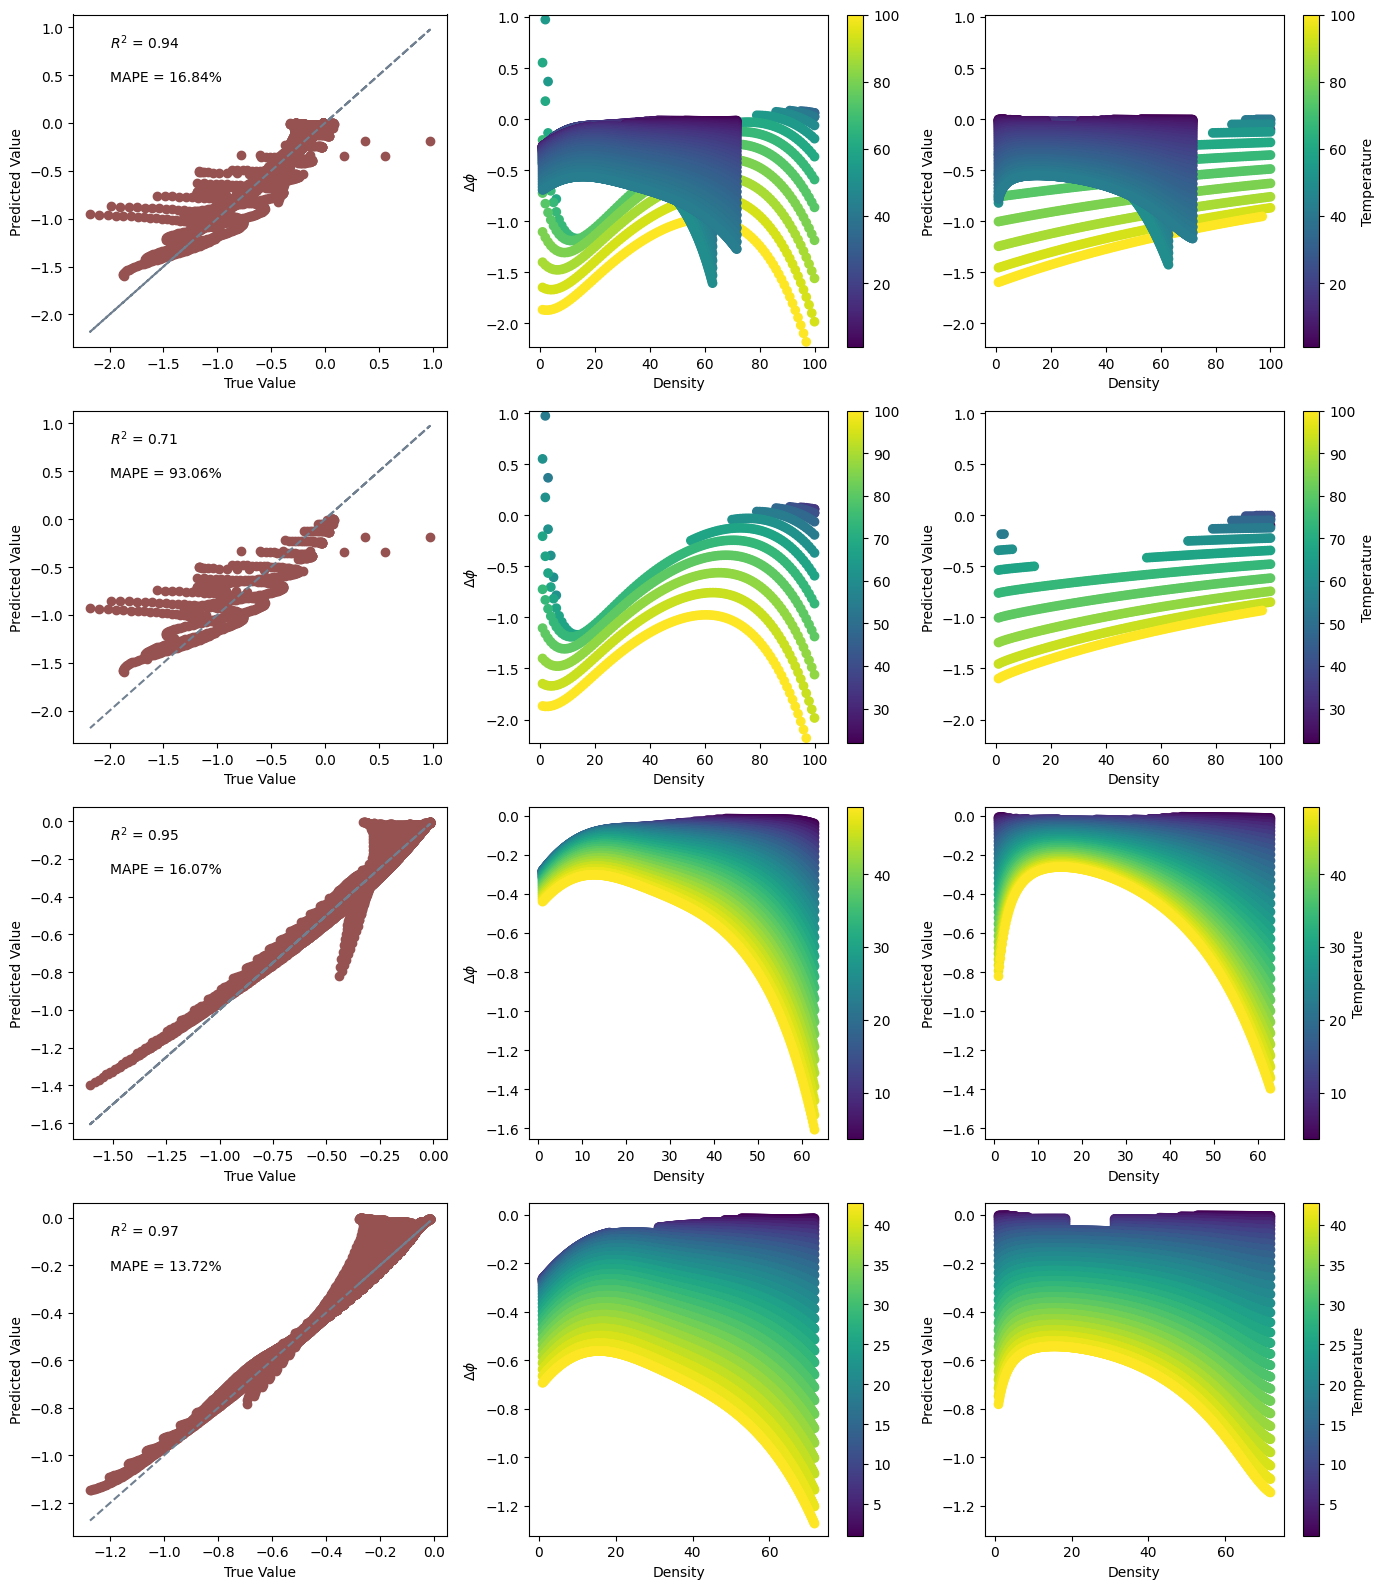

In [8]:
plot_predict(model, data_p)

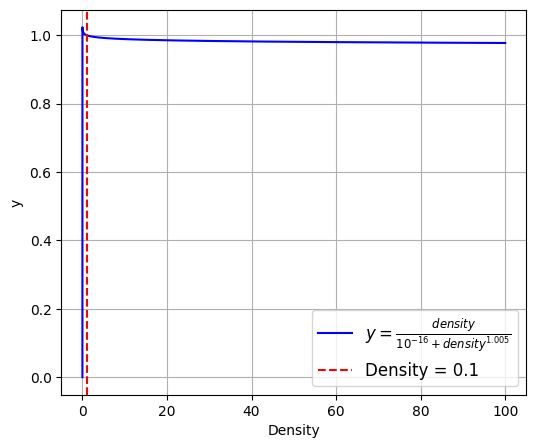

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define the density range
density = np.linspace(0, 100, 10000)  # Generate values from 0 to 10

# Define the custom weight function
weights = density / (10**(-16) + density**1.005)

# Plot the function
plt.figure(figsize=(6, 5))
plt.plot(density, weights, label=r'$y = \frac{density}{10^{-16} + density^{1.005}}$', color='blue')
plt.xlabel('Density')
plt.ylabel('y')
# plot x = 0.1
plt.axvline(x=1, color='red', linestyle='--', label='Density = 0.1')
plt.grid(True)
plt.legend(fontsize=12)
plt.show()



In [9]:
# print the equation and its complexity
best_model = model.get_best()
print(best_model)

complexity                                                                                                                                                                                                                                               35
loss                                                                                                                                                                                                                                               0.004114
score                                                                                                                                                                                                                                              0.006345
equation               sinh(((cos(tan(log(sinh(2.7793934) + (density / TPSA)))) / (sqrt(sqrt(HallKierAlpha)) * square(0.9771022))) + sinh(-0.92294526)) * square(sin(square((-0.11291606 * sqrt(TPSA + (temperature + cos(HallKierAlpha)))) * 1.3372

In [26]:
density,temperature  = sp.symbols('density temperature')
new_eqaution = density*model.sympy()
print(new_eqaution)

density*sinh((-1.05967238552385 + 1.04741796315203*cos(tan(log(8.02358498178744 + density/TPSA)))/HallKierAlpha**(1/4))*sin(0.0227997295137123*TPSA + 0.0227997295137123*temperature + 0.0227997295137123*cos(HallKierAlpha))**2)


In [10]:
from sympy import diff
equation = model.sympy()
symbols_in_equation = equation.free_symbols
print("Symbols in the equation:", symbols_in_equation)
partials = {str(sym): diff(equation, sym) for sym in symbols_in_equation}
print("\nPartial derivatives:")
for sym, derivative in partials.items():
    print(f"∂/∂{sym}:", derivative)

Symbols in the equation: {TPSA, HallKierAlpha, density, temperature}

Partial derivatives:
∂/∂TPSA: (0.0455994590274246*(-1.05967238552385 + 1.04741796315203*cos(tan(log(8.02358498178744 + density/TPSA)))/HallKierAlpha**(1/4))*sin(0.0227997295137123*TPSA + 0.0227997295137123*temperature + 0.0227997295137123*cos(HallKierAlpha))*cos(0.0227997295137123*TPSA + 0.0227997295137123*temperature + 0.0227997295137123*cos(HallKierAlpha)) + 1.04741796315203*density*(tan(log(8.02358498178744 + density/TPSA))**2 + 1)*sin(0.0227997295137123*TPSA + 0.0227997295137123*temperature + 0.0227997295137123*cos(HallKierAlpha))**2*sin(tan(log(8.02358498178744 + density/TPSA)))/(HallKierAlpha**(1/4)*TPSA**2*(8.02358498178744 + density/TPSA)))*cosh((-1.05967238552385 + 1.04741796315203*cos(tan(log(8.02358498178744 + density/TPSA)))/HallKierAlpha**(1/4))*sin(0.0227997295137123*TPSA + 0.0227997295137123*temperature + 0.0227997295137123*cos(HallKierAlpha))**2)
∂/∂HallKierAlpha: (-0.0455994590274246*(-1.059672385523

In [34]:
from restriction import Restriction
Restriction(model).restriction_check()

Evaluating restrictions for sinh((-1.05967238552385 + 1.04741796315203*cos(tan(log(8.02358498178744 + density/TPSA)))/HallKierAlpha**(1/4))*sin(0.0227997295137123*TPSA + 0.0227997295137123*temperature + 0.0227997295137123*cos(HallKierAlpha))**2)
Helmholtz Energy restrictions:
  Restriction 1: Not satisfied
  Restriction 2: Not satisfied
Pressure restrictions:
  Restriction 1: Not satisfied
  Restriction 2: Not satisfied
Internal Energy restrictions:
  Restriction 1: Not satisfied
  Restriction 2: Not satisfied
Isochoric Heat Capacity restrictions:
  Restriction: Not satisfied


{'Helmholtz Energy': (False, None),
 'Pressure': (False, None),
 'Internal Energy': (False, None),
 'Isochoric Heat Capacity': False}

In [55]:
import pandas as pd
data_a = pd.read_csv('data/processed_data/all_add_features_filtered_normalized.csv')
data= pd.read_csv('data/processed_data/exclude_2.csv')
data_n = pd.read_csv('data/processed_data/exclude_add_features_normalized.csv')
data_fn = pd.read_csv('data/processed_data/exclude_add_features_filtered_normalized.csv')

In [12]:
data_p

,density,temperature,TPSA,MW,LogP,HallKierAlpha,delta_phi
0,100.000000,21.842105,100.0,9.166827,1.000000,1.0,0.025229
1,98.000000,28.355263,100.0,9.166827,1.000000,1.0,0.059311
2,99.000000,28.355263,100.0,9.166827,1.000000,1.0,0.060031
3,100.000000,28.355263,100.0,9.166827,1.000000,1.0,0.060048
4,95.000000,34.868421,100.0,9.166827,1.000000,1.0,0.078612
...,...,...,...,...,...,...,...
25775,71.147437,42.684211,1.0,100.000000,56.890813,100.0,-1.253429
25776,71.289149,42.684211,1.0,100.000000,56.890813,100.0,-1.258414
25777,71.430861,42.684211,1.0,100.000000,56.890813,100.0,-1.263437
25778,71.572573,42.684211,1.0,100.000000,56.890813,100.0,-1.268500


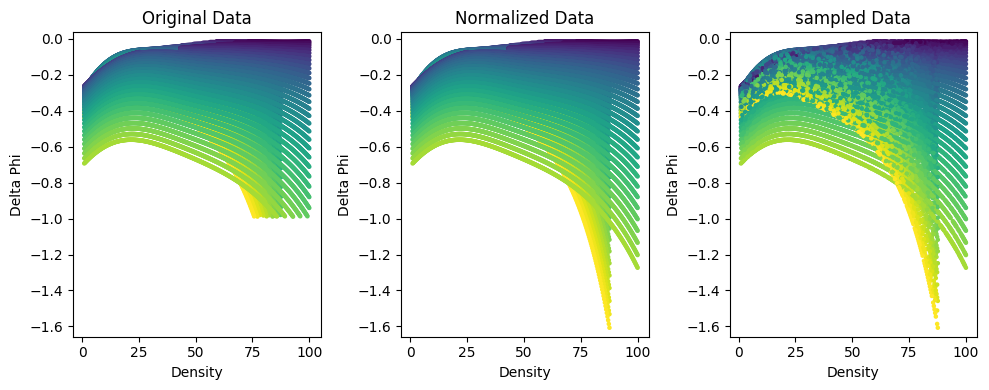

In [34]:
ymax = max(data_fn['delta_phi'].max(), data_n['delta_phi'].max()) + 0.05
ymin = min(data_fn['delta_phi'].min(), data_n['delta_phi'].min()) - 0.05
plt.figure(figsize=(10, 4))
plt.subplot(1,3,1)
plt.scatter(data_fn['density'], data_fn['delta_phi'], c=data_fn['temperature'], cmap='viridis', s=5)
plt.xlabel('Density')
plt.ylabel('Delta Phi')
plt.ylim(ymin, ymax)
plt.title('Original Data')

plt.subplot(1,3,2)
plt.scatter(data_n['density'], data_n['delta_phi'], c=data_n['temperature'], cmap='viridis', s=5)
plt.xlabel('Density')
plt.ylabel('Delta Phi')
plt.ylim(ymin, ymax)
plt.title('Normalized Data')

plt.subplot(1,3,3)
plt.scatter(data_n_sample['density'], data_n_sample['delta_phi'], c=data_n_sample['temperature'], cmap='viridis', s=5)
plt.xlabel('Density')
plt.ylabel('Delta Phi')
plt.ylim(ymin, ymax)
plt.title('sampled Data')
plt.tight_layout()
plt.show()